# Visualize module overlap

In [14]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from io import BytesIO
from PIL import Image

from config import PIPELINE_RUN_DIR, AMIMS, NETWORKS, SEED_SETS
from functions import split_module_id

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
path = os.path.join(PIPELINE_RUN_DIR, "main/results/mqc_summaries/jaccard_similarity_matrix_mqc.tsv")
path_no_seeds = os.path.join(PIPELINE_RUN_DIR, "main/results/mqc_summaries/jaccard_similarity_no_seeds_matrix_mqc.tsv")

In [19]:
amim_meta_df = pd.DataFrame.from_dict(AMIMS)
network_meta_df = pd.DataFrame.from_dict(NETWORKS)
seed_meta_df = pd.DataFrame.from_dict(SEED_SETS)

df = pd.read_csv(path, sep="\t")

ann_df = pd.DataFrame()
ann_df[["seed_id","network_id","amim_id"]] = df.ID.apply(split_module_id)
ann_df.set_index(df.ID, inplace=True)

no_seeds_df = pd.read_csv(path_no_seeds, sep="\t")
ann_no_seeds_df = pd.DataFrame()
ann_no_seeds_df[["seed_id","network_id","amim_id"]] = no_seeds_df.ID.apply(split_module_id)
ann_no_seeds_df.set_index(no_seeds_df.ID, inplace=True)

df.set_index("ID", inplace=True, drop=True)
no_seeds_df.set_index("ID", inplace=True, drop=True)

/home/johannes/micromamba/envs/mdp_demonstration/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/johannes/micromamba/envs/mdp_demonstration/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


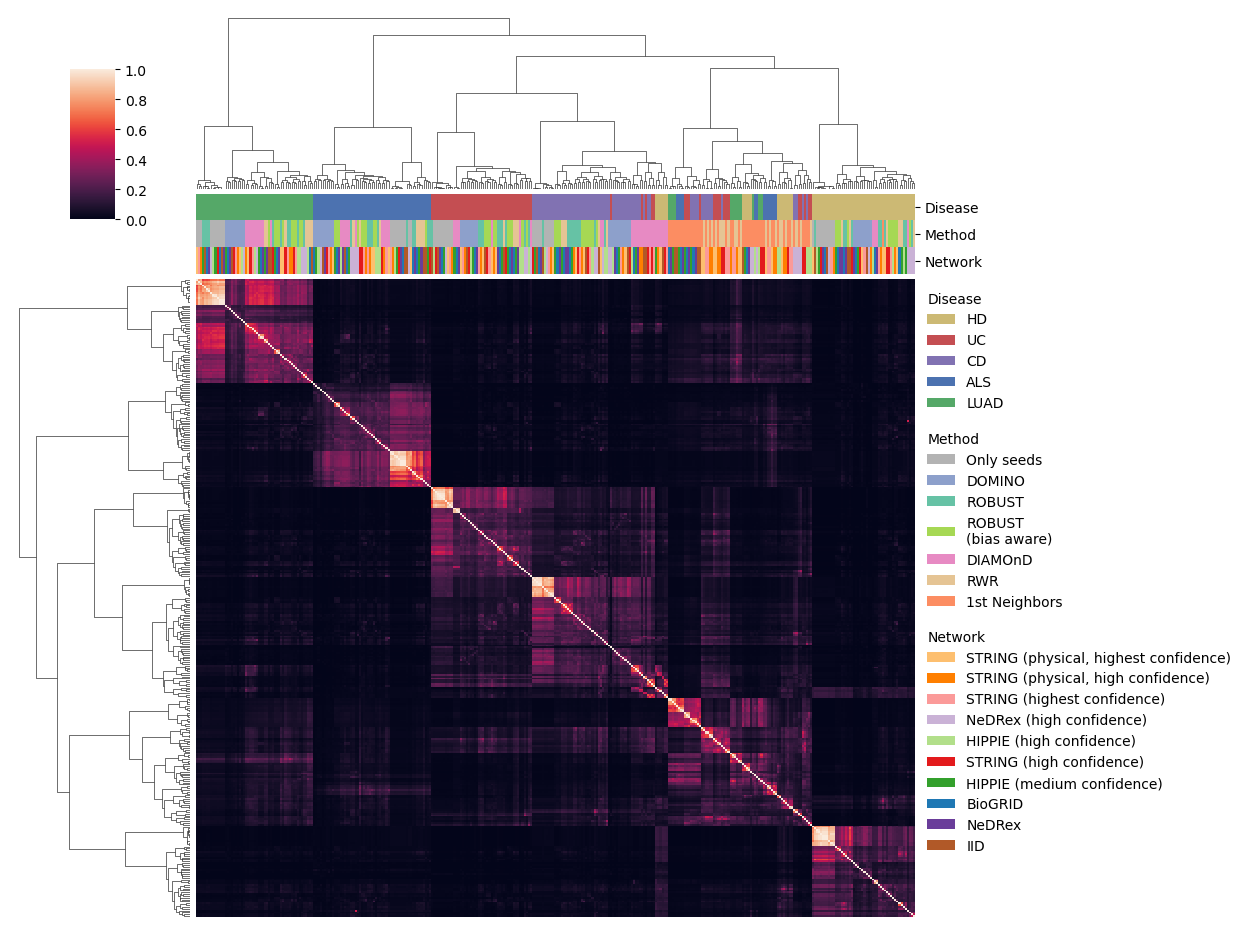

/home/johannes/micromamba/envs/mdp_demonstration/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/johannes/micromamba/envs/mdp_demonstration/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


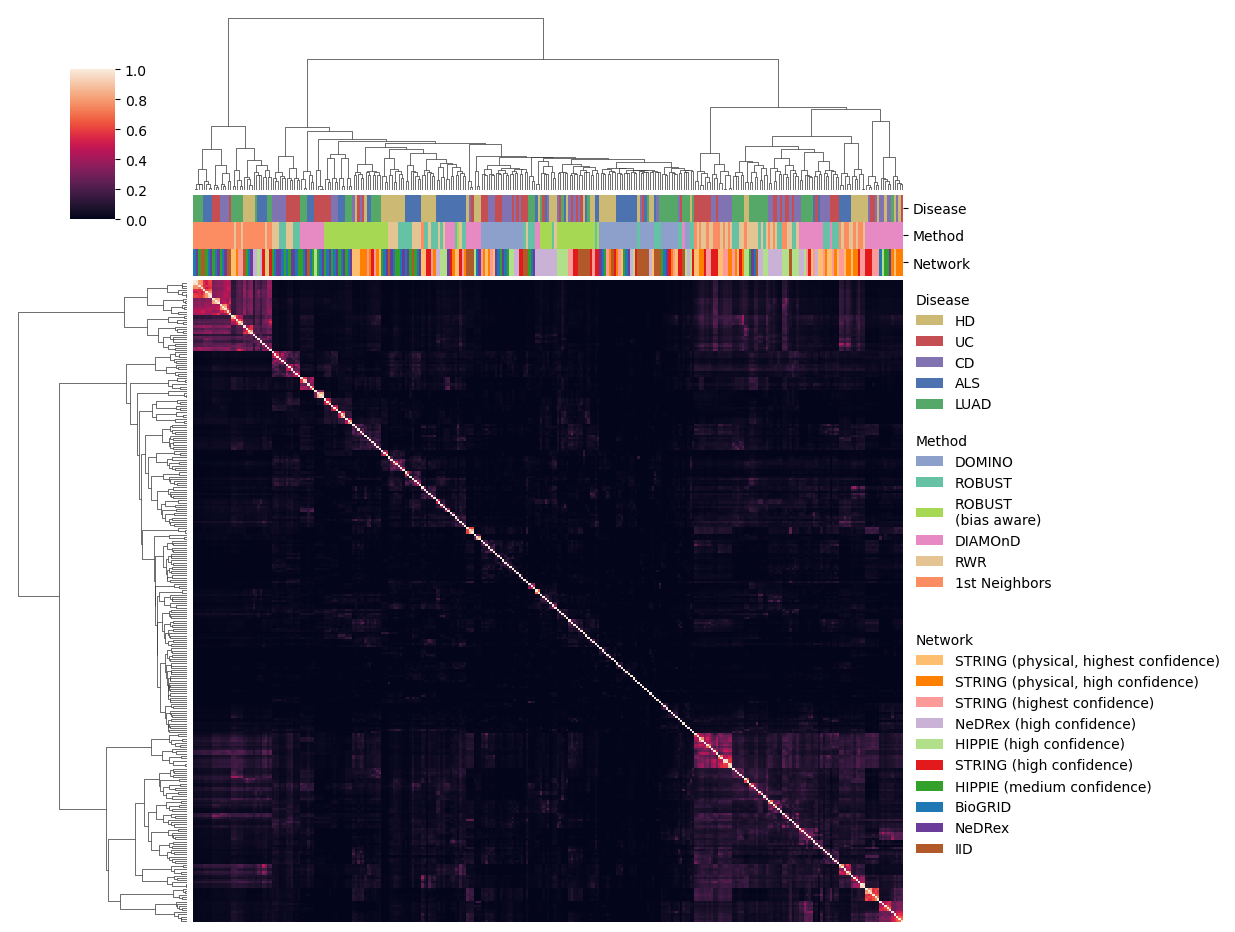

In [25]:
def combined_heatmap(df, ann_df, amim_meta_df, network_meta_df, seed_meta_df):
    color_df = pd.DataFrame()
    color_df["Disease"] = ann_df.seed_id.map(dict(zip(seed_meta_df.short, seed_meta_df.color)))
    color_df["Method"] = ann_df.amim_id.map(dict(zip(amim_meta_df.id, amim_meta_df.color)))
    color_df["Network"] = ann_df.network_id.map(dict(zip(network_meta_df.id, network_meta_df.color)))

    g = sns.clustermap(
        data=df,
        col_colors=color_df,
        figsize=(15, 15),
        cbar_pos=(0.05, 0.85, 0.03, 0.1),
        method="ward",
    )
    g.ax_heatmap.set_xticks([])
    g.ax_heatmap.set_yticks([])
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.set_xlabel("")

    handles = [Patch(facecolor=color, label=group) for group, color in zip(seed_meta_df.short, seed_meta_df.color)]
    disease_legend  = g.ax_heatmap.legend(
        handles=handles,
        title='Disease',
        loc='upper left',
        bbox_to_anchor=(1, 1),  # adjust position as needed
        frameon=False,
    )
    disease_legend._legend_box.align = "left"
    g.ax_heatmap.add_artist(disease_legend)

    handles = [Patch(facecolor=color, label=group) for group, color in zip(amim_meta_df.label, amim_meta_df.color)]
    method_legend = g.ax_heatmap.legend(
        handles=handles,
        title='Method',
        loc='upper left',
        bbox_to_anchor=(1, 0.78),  # adjust position as needed
        frameon=False,
    )
    method_legend._legend_box.align = "left"
    g.ax_heatmap.add_artist(method_legend)

    handles = [Patch(facecolor=color, label=group) for group, color in zip(network_meta_df.label, network_meta_df.color)]
    network_legend = g.ax_heatmap.legend(
        handles=handles,
        title='Network',
        loc='upper left',
        bbox_to_anchor=(1, 0.47),  # adjust position as needed
        frameon=False,
    )
    network_legend._legend_box.align = "left"
    #g.ax_heatmap.add_artist(network_legend)

    plt.show()
    return g

# Generate the heatmaps for both with and without seeds
combined_heatmap(df, ann_df, amim_meta_df, network_meta_df, seed_meta_df)
combined_heatmap(no_seeds_df, ann_no_seeds_df, amim_meta_df[amim_meta_df.id!="no_tool"], network_meta_df, seed_meta_df)

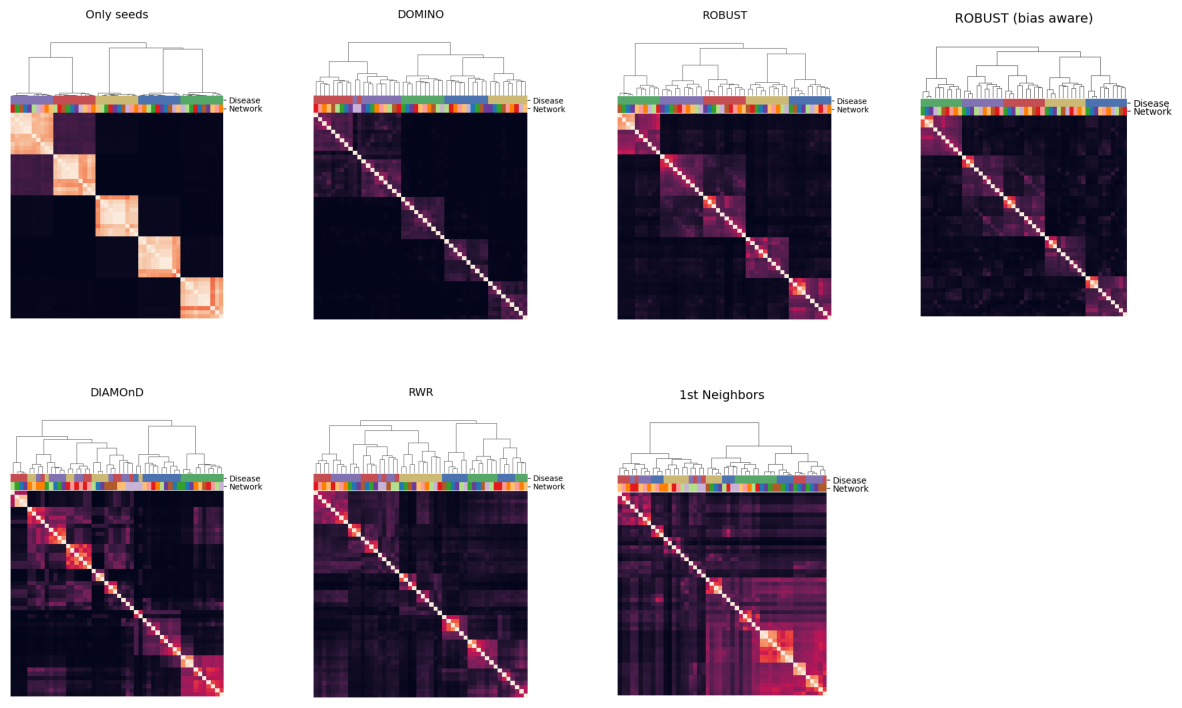

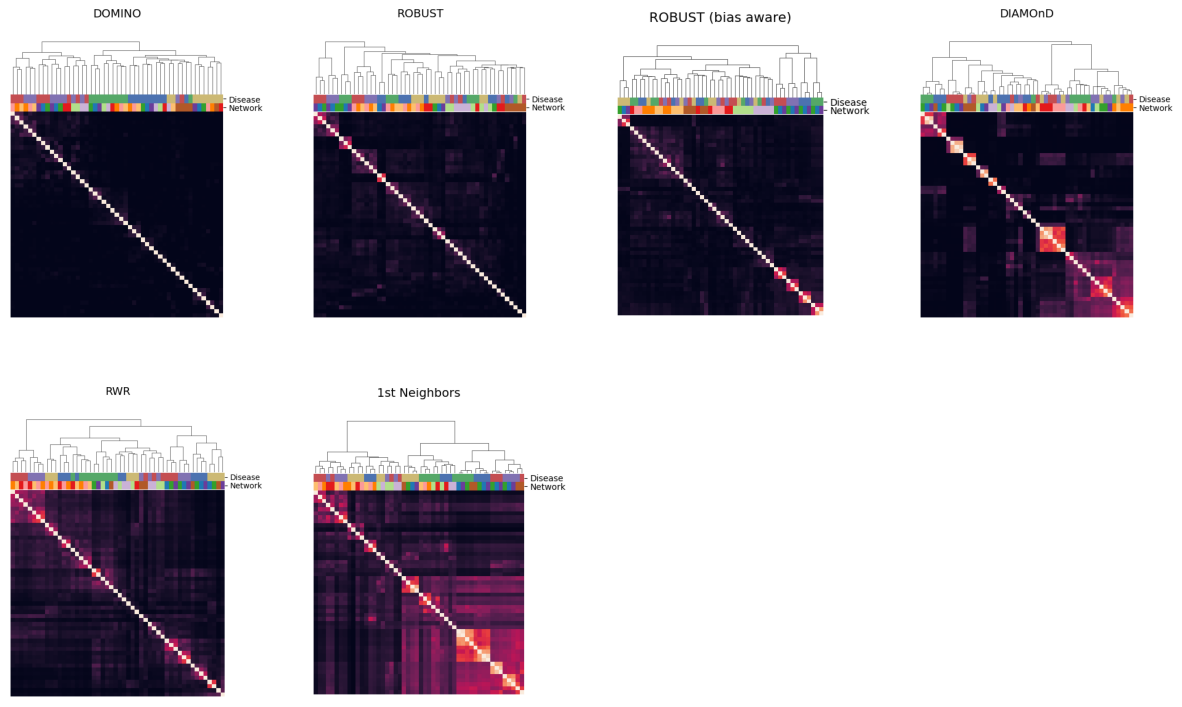

In [27]:
def heatmaps_per_method(df, ann_df, amim_meta_df, network_meta_df, seed_meta_df):
    # Map colors
    color_df = pd.DataFrame()
    color_df["Disease"] = ann_df.seed_id.map(dict(zip(seed_meta_df.short, seed_meta_df.color)))
    color_df["Network"] = ann_df.network_id.map(dict(zip(network_meta_df.id, network_meta_df.color)))

    # Prepare list for storing images
    heatmap_images = []

    # Loop over methods
    for amim_id in amim_meta_df.id:
        method_name = amim_meta_df.loc[amim_meta_df.id == amim_id, "label"].values[0]
        mask = ann_df.amim_id == amim_id
        df_subset = df.loc[mask, mask]
        color_df_subset = color_df.loc[mask]

        # Create clustermap
        g = sns.clustermap(
            data=df_subset,
            col_colors=color_df_subset,
            figsize=(10, 10),  # smaller since we combine later
            cbar_pos=None,   # disable color bar for clarity
            method="ward",
        )

        g.ax_row_dendrogram.set_visible(False)
        g.ax_heatmap.set_xticks([])
        g.ax_heatmap.set_yticks([])
        g.ax_heatmap.set_ylabel("")
        g.ax_heatmap.set_xlabel("")
        g.ax_heatmap.text(
            0.5, 1.45, f"{method_name.replace('\n', ' ')}",
            fontsize=14,
            ha='center',
            va='bottom',
            transform=g.ax_heatmap.transAxes
        )

        #plt.show()
        # Save figure to buffer
        buf = BytesIO()
        g.figure.savefig(buf, format="png", bbox_inches='tight', pad_inches=0.01)
        buf.seek(0)
        img = Image.open(buf)
        heatmap_images.append(img)
        plt.close(g.figure)  # Close to avoid display

    # Create final figure with 4 cols x 2 rows
    fig = plt.figure(figsize=(15, 9))
    gs = GridSpec(2, 4, figure=fig)

    for i, img in enumerate(heatmap_images):
        row = i // 4
        col = i % 4
        ax = fig.add_subplot(gs[row, col])
        ax.imshow(img)
        ax.axis('off')  # Hide axes

    plt.show()
heatmaps_per_method(df, ann_df, amim_meta_df, network_meta_df, seed_meta_df)
heatmaps_per_method(no_seeds_df, ann_no_seeds_df, amim_meta_df[amim_meta_df.id!="no_tool"], network_meta_df, seed_meta_df)

# Network impact

In [29]:
def overlap_across_networks(df, ann_df, amim_meta_df, seed_meta_df):
    overlap_across_networks_df = []
    for amim_id in amim_meta_df.id:
        for seed_id in seed_meta_df.short:
            mask = (ann_df.amim_id == amim_id) & (ann_df.seed_id == seed_id)
            df_subset = df.loc[mask, mask]
            # turn into a 2D numpy array
            df_subset = df_subset.values
            # Create a mask for the upper triangle
            upper_triangle = df_subset[np.triu_indices(df_subset.shape[0], k = 1)]
            upper_triangle_df = pd.DataFrame()
            upper_triangle_df["jaccard"] = upper_triangle
            upper_triangle_df["amim_id"] = amim_id
            upper_triangle_df["seed_id"] = seed_id
            overlap_across_networks_df.append(upper_triangle_df)
    overlap_across_networks_df = pd.concat(overlap_across_networks_df)
    overlap_across_networks_df["method"] = overlap_across_networks_df.amim_id.map(dict(zip(amim_meta_df.id, amim_meta_df.label)))
    return overlap_across_networks_df
overlap_across_networks_df = overlap_across_networks(df, ann_df, amim_meta_df, seed_meta_df)
overlap_across_networks_no_seeds_df = overlap_across_networks(no_seeds_df, ann_no_seeds_df, amim_meta_df[amim_meta_df.id!="no_tool"], seed_meta_df)




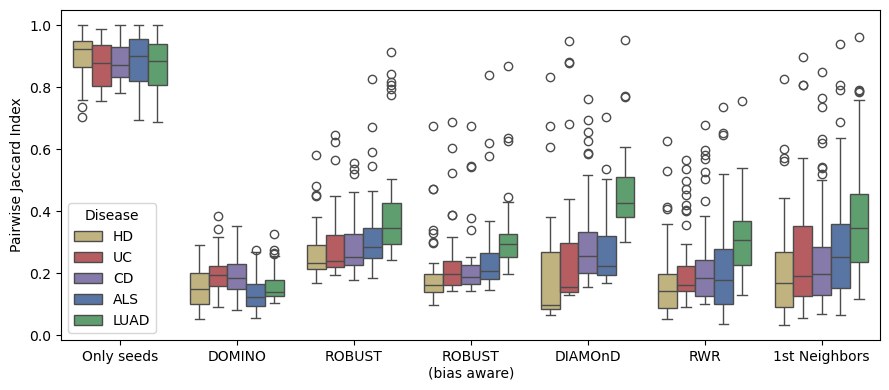

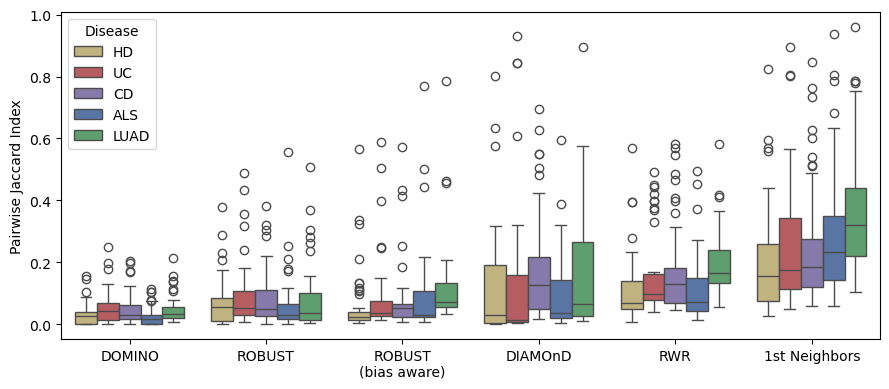

In [31]:
# visualize as boxplot
plt.figure(figsize=(9, 4))
sns.boxplot(
    data=overlap_across_networks_df,
    x="method",
    y="jaccard",
    hue="seed_id",
    hue_order=seed_meta_df.short,
    order=amim_meta_df.label,
    palette=dict(zip(seed_meta_df.short, seed_meta_df.color)),
)
plt.xlabel("")
plt.ylabel("Pairwise Jaccard Index")
plt.legend(title="Disease")
plt.tight_layout()
plt.show()
plt.show()

# visualize as boxplot
plt.figure(figsize=(9, 4))
sns.boxplot(
    data=overlap_across_networks_no_seeds_df,
    x="method",
    y="jaccard",
    hue="seed_id",
    hue_order=seed_meta_df.short,
    order=amim_meta_df[amim_meta_df.id!="no_tool"].label,
    palette=dict(zip(seed_meta_df.short, seed_meta_df.color)),
)
plt.xlabel("")
plt.ylabel("Pairwise Jaccard Index")
plt.legend(title="Disease")
plt.tight_layout()
plt.show()
plt.show()